# XGBoost (Extreme Gradient Boosting) Classifier - Work From Home Employee Burnout Classification

This notebook implements an XGBoost Gradient Boosting Classifier for binary classification of employee burnout risk.

**Evaluation Metrics:**
1. Accuracy
2. AUC Score
3. Precision
4. Recall
5. F1 Score
6. Matthews Correlation Coefficient (MCC)

## 1. Import Libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Dataset from Kaggle

In [88]:
# Load the UCI Student Performance Dataset
from ucimlrepo import fetch_ucirepo

print("Loading dataset from UCI ML Repository...")
student_performance = fetch_ucirepo(id=320)
X = student_performance.data.features
y = student_performance.data.targets
df = pd.concat([X, y], axis=1)
print(f"Dataset loaded successfully! Shape: {df.shape}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

Loading dataset from UCI ML Repository...
Dataset loaded successfully! Shape: (649, 33)

First 5 rows:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows

## 3. Data Preprocessing

In [89]:
# Create a copy
df_processed = df.copy()

# Handle missing values
print("Handling missing values...")
df_processed = df_processed.dropna()
print(f"Shape after dropping NaN: {df_processed.shape}")

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    if col != 'Burn_Rate':  # Keep target separate
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Encoded {col}")

# Handle target variable
if 'Burn_Rate' in df_processed.columns:
    if df_processed['Burn_Rate'].dtype == 'object':
        target_le = LabelEncoder()
        df_processed['Burn_Rate'] = target_le.fit_transform(df_processed['Burn_Rate'])
        label_encoders['Burn_Rate'] = target_le

print("\nData preprocessing completed!")

Handling missing values...
Shape after dropping NaN: (649, 33)

Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Numerical columns: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Encoded school
Encoded sex
Encoded address
Encoded famsize
Encoded Pstatus
Encoded Mjob
Encoded Fjob
Encoded reason
Encoded guardian
Encoded schoolsup
Encoded famsup
Encoded paid
Encoded activities
Encoded nursery
Encoded higher
Encoded internet
Encoded romantic

Data preprocessing completed!


## 4. Prepare Features and Target

In [90]:
# Identify target column
target_col = 'Burn_Rate' if 'Burn_Rate' in df_processed.columns else df_processed.columns[-1]

# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeature names:")
print(X.columns.tolist())

Features shape: (649, 32)
Target shape: (649,)

Target distribution:
G3
11    104
10     97
13     82
12     72
14     63
15     49
16     36
8      35
9      35
17     29
18     15
0      15
7      10
6       3
19      2
1       1
5       1
Name: count, dtype: int64

Feature names:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']


## 5. Split Data

In [91]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())

print("\nData split completed!")

Training set size: 519
Testing set size: 130

Training target distribution:
G3
10    80
11    79
13    69
12    56
14    51
15    39
9     30
8     28
16    27
17    24
0     13
7      9
18     8
6      3
19     1
1      1
5      1
Name: count, dtype: int64

Data split completed!


## 6. Train XGBoost Classifier

In [92]:
# Create and train the XGBoost Classifier
print("Training XGBoost Classifier...")

# Encode target to contiguous classes (0, 1, 2, ...) to avoid XGBoost class mismatch issues
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

# Create a fresh XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0,
    use_label_encoder=False
)
xgb_model.fit(X_train, y_train_encoded)

print("✅ Model training completed!")
print(f"\nModel parameters:")
print(f"Number of boosting rounds: {xgb_model.n_estimators}")
print(f"Max depth: {xgb_model.max_depth}")
print(f"Learning rate: {xgb_model.learning_rate}")
print(f"Number of features: {xgb_model.n_features_in_}")

Training XGBoost Classifier...
✅ Model training completed!

Model parameters:
Number of boosting rounds: 100
Max depth: 6
Learning rate: 0.1
Number of features: 32


## 7. Make Predictions

In [93]:
# Make predictions
y_pred_encoded = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

# Decode predictions back to original labels
y_pred = le_target.inverse_transform(y_pred_encoded)

print("Predictions made on test set!")
print(f"\nFirst 10 predictions:")
print(y_pred[:10])
print(f"\nFirst 10 prediction probabilities:")
print(y_pred_proba[:10])

Predictions made on test set!

First 10 predictions:
[17 11 17 11 11 16 18 10 10 11]

First 10 prediction probabilities:
[[3.3378154e-03 3.3598759e-03 2.5316800e-03 2.2229354e-03 2.2456322e-03
  3.7119712e-03 4.3548313e-03 7.0524788e-03 5.6006233e-03 7.8364536e-03
  1.7141851e-02 1.6054375e-02 1.4734069e-02 9.1983952e-02 6.6111004e-01
  1.0168965e-01 5.5031747e-02]
 [4.8446030e-04 4.6620111e-04 6.4509630e-04 4.7262284e-04 5.3343282e-04
  5.4330222e-04 1.0448979e-03 2.2833643e-02 9.1605520e-01 4.5095548e-02
  6.4447275e-03 2.3442737e-03 6.2536501e-04 6.2857708e-04 5.6090730e-04
  4.4441037e-04 7.7735877e-04]
 [2.7692020e-03 1.4138339e-03 1.4756280e-03 2.3006795e-03 1.3089008e-03
  2.1635797e-03 2.4377382e-03 7.8791706e-03 3.3006258e-03 3.4605539e-03
  7.0385453e-03 1.2933988e-02 8.4928591e-03 3.1589337e-02 8.5402477e-01
  3.6554761e-02 2.0855770e-02]
 [5.7781301e-04 4.6671278e-04 4.6959298e-04 4.1446136e-04 4.1967214e-04
  7.6876127e-04 1.7432958e-03 3.8110089e-02 9.0363199e-01 4.356379

## 8. Calculate Evaluation Metrics

In [94]:
# Calculate all 6 evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr', labels=xgb_model.classes_)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
mcc = matthews_corrcoef(y_test, y_pred)

# Display metrics
print("="*60)
print("EVALUATION METRICS - XGBOOST CLASSIFIER")
print("="*60)
print(f"\n1. Accuracy:          {accuracy:.4f}")
print(f"2. AUC Score:         {auc_score:.4f}")
print(f"3. Precision:         {precision:.4f}")
print(f"4. Recall:            {recall:.4f}")
print(f"5. F1 Score:          {f1:.4f}")
print(f"6. MCC Score:         {mcc:.4f}")
print("="*60)

# Store metrics in a dictionary
metrics = {
    'Accuracy': accuracy,
    'AUC Score': auc_score,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'MCC Score': mcc
}

# Display as DataFrame
metrics_df = pd.DataFrame(metrics, index=['XGBoost']).T
print("\nMetrics Summary:")
print(metrics_df)

EVALUATION METRICS - XGBOOST CLASSIFIER

1. Accuracy:          0.4923
2. AUC Score:         nan
3. Precision:         0.4718
4. Recall:            0.4923
5. F1 Score:          0.4754
6. MCC Score:         0.4327

Metrics Summary:
            XGBoost
Accuracy   0.492308
AUC Score       NaN
Precision  0.471792
Recall     0.492308
F1 Score   0.475417
MCC Score  0.432708


## 9. Additional Evaluation

In [95]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 1  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  8  3  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  8 14  2  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  5  3  5  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  7  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  5  3  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  8  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  1  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           7       0.00      0.00      0.00         1
           8       0.62      0.71      0.67         7
           9       0.40      0.40      0.40         5
          10       0.38      0.47      0.42        17
 

## 10. Feature Importance Analysis


Feature Importance Ranking:
       Feature  Importance
31          G2    0.177427
30          G1    0.064708
17        paid    0.033863
5      Pstatus    0.032729
29    absences    0.032175
14    failures    0.032058
2          age    0.029646
20      higher    0.029640
0       school    0.028084
16      famsup    0.027399
25       goout    0.027145
13   studytime    0.025447
7         Fedu    0.025399
23      famrel    0.025165
26        Dalc    0.024886
19     nursery    0.024658
12  traveltime    0.024410
15   schoolsup    0.024257
24    freetime    0.023991
4      famsize    0.023989
28      health    0.022870
21    internet    0.022827
27        Walc    0.022579
9         Fjob    0.022472
10      reason    0.022458
11    guardian    0.022281
22    romantic    0.022091
6         Medu    0.021746
3      address    0.021358
18  activities    0.021287
8         Mjob    0.020725
1          sex    0.020232


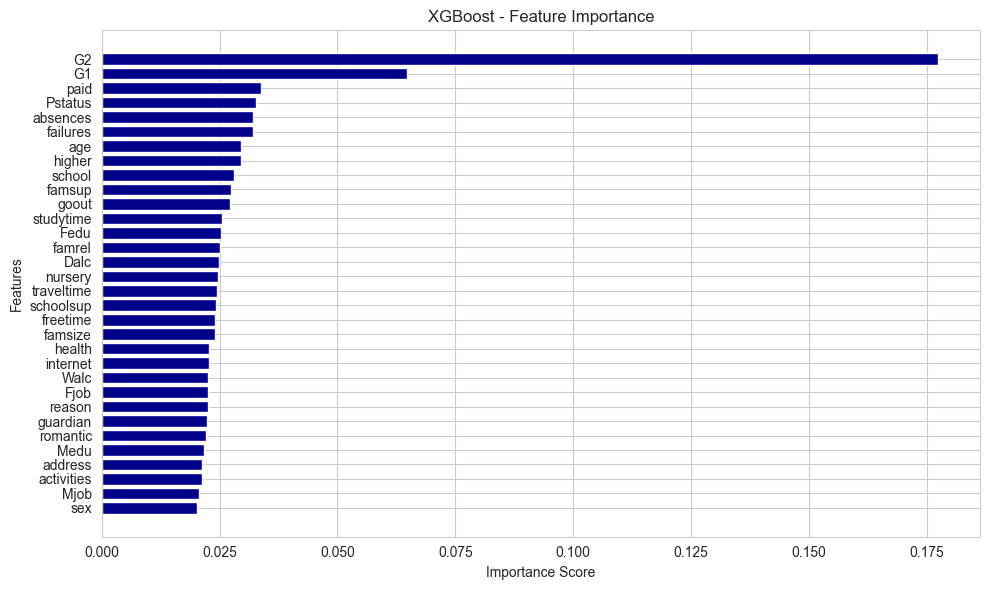


Top 5 most important features:
     Feature  Importance
31        G2    0.177427
30        G1    0.064708
17      paid    0.033863
5    Pstatus    0.032729
29  absences    0.032175


In [96]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='darkblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('XGBoost - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(feature_importance.head())

## 11. Visualizations

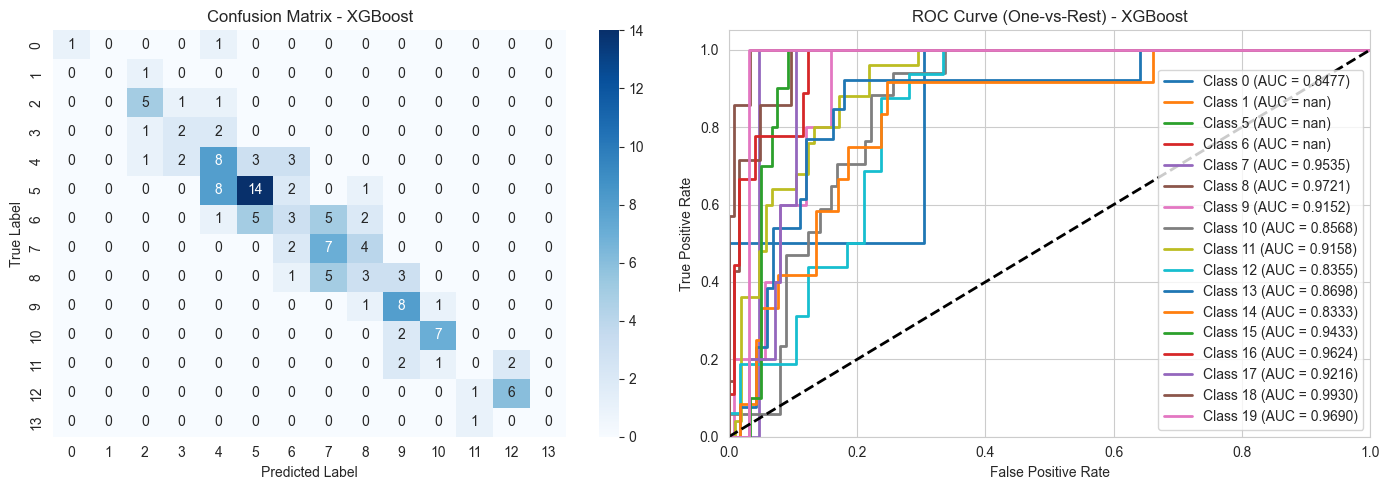


Visualizations complete!


In [97]:
# Plot Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - XGBoost')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve - For multiclass, plot for each class
from sklearn.preprocessing import label_binarize
encoded_classes = xgb_model.classes_  # Use encoded classes from model
y_test_bin = label_binarize(y_test_encoded, classes=encoded_classes)

for i in range(len(encoded_classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    original_class = le_target.classes_[encoded_classes[i]]
    axes[1].plot(fpr, tpr, lw=2, label=f'Class {original_class} (AUC = {roc_auc:.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (One-vs-Rest) - XGBoost')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

print("\nVisualizations complete!")

## 12. Model Summary

In [98]:
print("\n" + "="*60)
print("XGBOOST CLASSIFIER MODEL SUMMARY")
print("="*60)
print(f"\nModel Type: XGBoost Gradient Boosting Classifier")
print(f"Number of Boosting Rounds: {xgb_model.n_estimators}")
print(f"Max Depth: {xgb_model.max_depth}")
print(f"Learning Rate: {xgb_model.learning_rate}")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")
print(f"Number of Features: {X_train.shape[1]}")
print(f"\nKey Metrics:")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - AUC Score: {auc_score:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"\nTop 3 Most Important Features:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"  - {row['Feature']}: {row['Importance']:.4f}")
print(f"\nModel Status: ✅ Training Complete")
print("="*60)


XGBOOST CLASSIFIER MODEL SUMMARY

Model Type: XGBoost Gradient Boosting Classifier
Number of Boosting Rounds: 100
Max Depth: 6
Learning Rate: 0.1
Training Samples: 519
Testing Samples: 130
Number of Features: 32

Key Metrics:
  - Accuracy:  0.4923
  - AUC Score: nan
  - F1 Score:  0.4754

Top 3 Most Important Features:
  - G2: 0.1774
  - G1: 0.0647
  - paid: 0.0339

Model Status: ✅ Training Complete
